In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, append_inverse_to_quantum_circuit, get_circuit_for_model, get_unitary_for_model_pennylane
from circuits.pqc_circuits import simple_PQC_pennylane

from simulator.simulate import get_ideal_shots, run_circuit_sim, get_ideal_data


In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    device = torch.device("mps")
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    device = torch.device("cuda")
else:
    print('Torch running on CPU')
    device = torch.device("cpu")

Torch running on Apple GPU


In [5]:
NUM_SHOTS = 10**4
NUM_QUBITS = 5
INPUT_BITS = '10101'
EPOCHS = 5
# fakeVigo2_backend = FakeVigoV2()
fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)

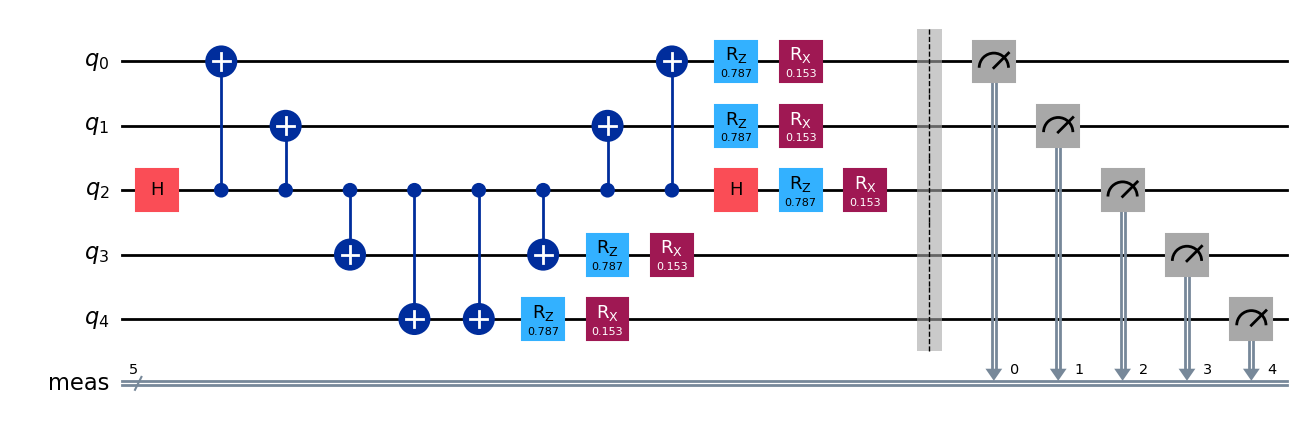

In [6]:
test_circ = append_inverse_to_quantum_circuit(custom_ghz(5, 2))
test_params = torch.rand(3)
# print(test_params)
# test_circ = test_circ.compose(test_circ.inverse())
test_circ_pqc = append_pqc_to_quantum_circuit(test_circ, test_params)
test_circ_pqc.draw('mpl')

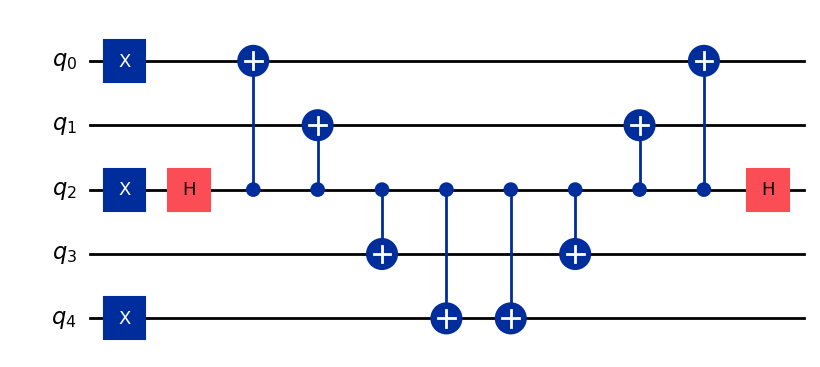

In [7]:
mcirc = get_circuit_for_model(INPUT_BITS, custom_ghz(5,2))
mcirc.draw('mpl')

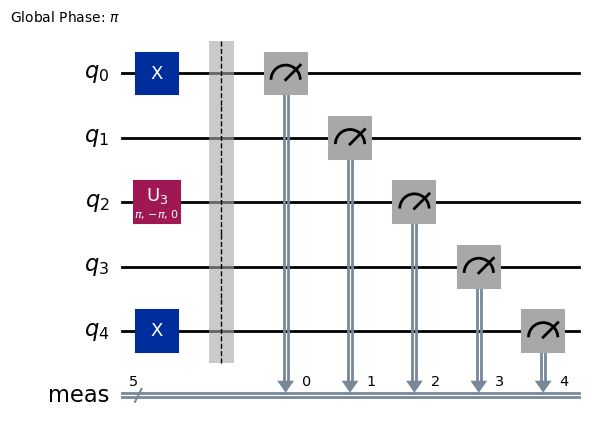

In [8]:
mcirc_measured = mcirc.measure_all(inplace=False)
ideal_sim = AerSimulator()
transpiled_circ = transpile(mcirc_measured, ideal_sim)
transpiled_circ.draw('mpl')

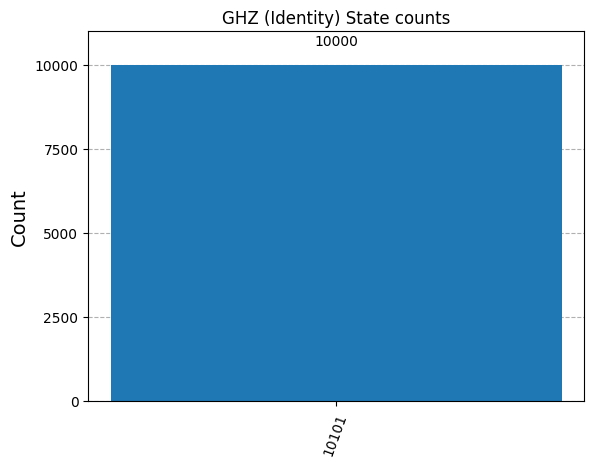

In [9]:
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)
plot_histogram(counts, title='GHZ (Identity) State counts')

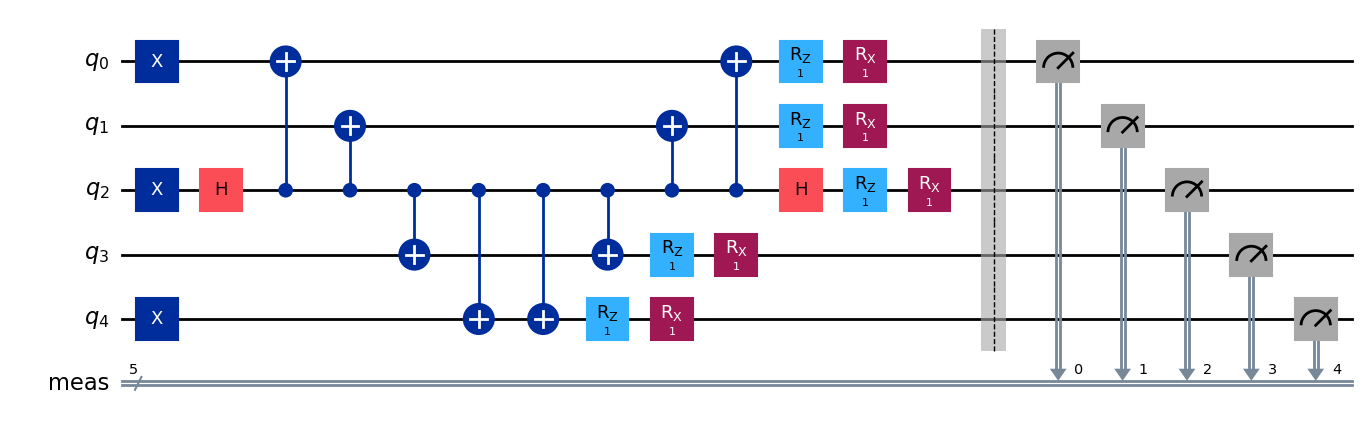

In [10]:
mcirc_pqc = append_pqc_to_quantum_circuit(mcirc, torch.ones(mcirc.num_qubits))
mcirc_pqc.draw('mpl')

In [11]:
ideal_counts = get_ideal_shots(input=INPUT_BITS, shots=NUM_SHOTS)
measured_counts = run_circuit_sim(circuit=mcirc_pqc, simulator=noisy_sim, num_shots=NUM_SHOTS)

print(ideal_counts)
print(measured_counts)

print(torch.dist(ideal_counts, measured_counts))

tensor([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 10000.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.])
tensor([  91,  232,   25,   87,  275,  776,   81,  261,   30,   80,    9,   28,
          71,  249,   27,   78,  233,  806,   65,  237,  773, 2630,  230,  835,
          75,  236,   18,   70,  241,  822,   73,  256])
tensor(7629.2104)


In [12]:
class SimpleCustomQuantumModel(nn.Module):
    def __init__(self, num_params:int, base_circuit: QuantumCircuit, 
                 simulator:AerSimulator=fakeAthensV2_backend, num_shots=NUM_SHOTS, 
                 circuit_runner = run_circuit_sim, param_init_noise=torch.pi/1000):
        super().__init__()

        self.pqc_params = nn.Parameter(param_init_noise * torch.rand(num_params))
        self.simulator = simulator
        self.transpile = transpile
        self.num_shots = num_shots
        self.runner = circuit_runner
        self.base_circuit = base_circuit
        self.pennylane_dev = qml.device("default.qubit", wires=self.base_circuit.num_qubits)

        pass

    
    def forward(self, unitary:Operator):
        """
        @param circuit: The quantum circuit with the input and it's inverse appended. 
        """    
        # circuit = circuit.remove_final_measurements(inplace=False)
        # circuit_pqc = append_pqc_to_quantum_circuit(circuit, self.pqc_params)
        # measured_tensor = self.runner(circuit_pqc, self.simulator, self.num_shots)

        # return measured_tensor

        qnode = self.make_pennylane_qnode()
        probs = qnode(self.pqc_params, unitary, self.base_circuit.num_qubits)
        # shots_scaled = probs * self.num_shots

        return probs

    

    
    def make_pennylane_qnode(self):
        dev = qml.device("default.qubit", wires=self.base_circuit.num_qubits)

        @qml.qnode(dev, interface="torch", diff_method="backprop")
        def pennylane_pqc_circ(params, unitary, num_qubits):
            qml.QubitUnitary(unitary, wires=range(num_qubits))  # fixed input/inverse
            simple_PQC_pennylane(num_qubits=num_qubits, params=params)
            
            return qml.probs(wires=range(num_qubits))

        return pennylane_pqc_circ



        


In [13]:
ideal_data = get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=5000, prob_dist=True)
print(len(ideal_data[10][1]))

32


In [14]:
ghz_circuit = custom_ghz(NUM_QUBITS, 2)
pqc_model = SimpleCustomQuantumModel(num_params=2, num_shots=NUM_SHOTS, base_circuit=ghz_circuit)

optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.005)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)


loss_fn = nn.MSELoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

print(device)

mps


In [15]:
param_list = []
loss_list = []
for i in range(EPOCHS):
    print(f'Starting Epoch {i+1}')
    pqc_model.train()
    ctr = 0
    for bitstring, ideal in ideal_data:
        ctr += 1
        optimizer.zero_grad()

        # measured = pqc_model(get_circuit_for_model(bitstring, ghz_circuit))
        model_unitary = get_unitary_for_model_pennylane(bitstring, pqc_model.base_circuit)

        # print(len(measured), len(ideal))
        measured = pqc_model(model_unitary)

        ideal = ideal.float().to(device)
        measured = measured.float().to(device)
        
        loss = loss_fn(measured, ideal)

        loss.backward()
        optimizer.step()
        # scheduler.step(loss)

        # with torch.no_grad():
        #     pqc_model.pqc_params[:] = pqc_model.pqc_params % (2 * torch.pi)



        param_values = pqc_model.pqc_params.detach().cpu().numpy()
        param_list.append(param_values)


        if (ctr) % (len(ideal_data) // 10) == 0:
            
            print(f'Count {ctr}, Loss: {loss:.4f}, Params: {pqc_model.pqc_params}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')

        # scheduler.step(loss)

    

Starting Epoch 1
Count 500, Loss: 0.0324, Params: Parameter containing:
tensor([0.0027, 1.0597], requires_grad=True)
Count 1000, Loss: 0.0213, Params: Parameter containing:
tensor([0.0026, 1.1078], requires_grad=True)
Count 1500, Loss: 0.0330, Params: Parameter containing:
tensor([0.0026, 1.1523], requires_grad=True)
Count 2000, Loss: 0.0332, Params: Parameter containing:
tensor([0.0025, 1.1304], requires_grad=True)
Count 2500, Loss: 0.0212, Params: Parameter containing:
tensor([0.0024, 1.1042], requires_grad=True)
Count 3000, Loss: 0.0247, Params: Parameter containing:
tensor([0.0024, 1.2338], requires_grad=True)
Count 3500, Loss: 0.0311, Params: Parameter containing:
tensor([0.0024, 1.1906], requires_grad=True)
Count 4000, Loss: 0.0225, Params: Parameter containing:
tensor([0.0023, 1.1477], requires_grad=True)
Count 4500, Loss: 0.0325, Params: Parameter containing:
tensor([0.0023, 1.0556], requires_grad=True)
Count 5000, Loss: 0.0336, Params: Parameter containing:
tensor([0.0022, 1.0

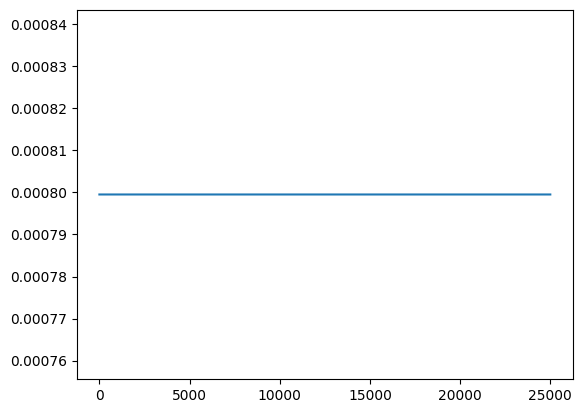

In [16]:
param_arr = np.array(param_list).transpose()
plt.plot([i for i in range(param_arr.shape[1])], param_arr[0])
plt.show()

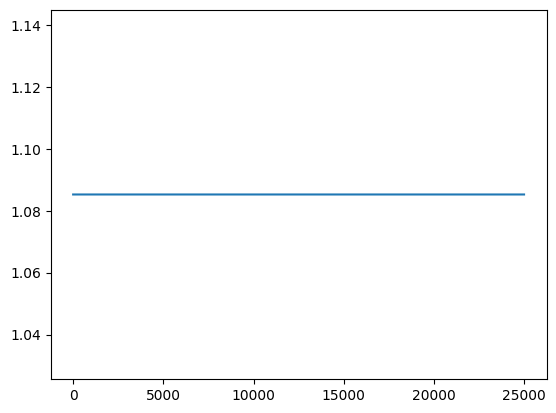

In [17]:
plt.plot([i for i in range(param_arr.shape[1])], param_arr[1])
plt.show()

In [18]:
pqc_model.pqc_params

Parameter containing:
tensor([7.9952e-04, 1.0853e+00], requires_grad=True)

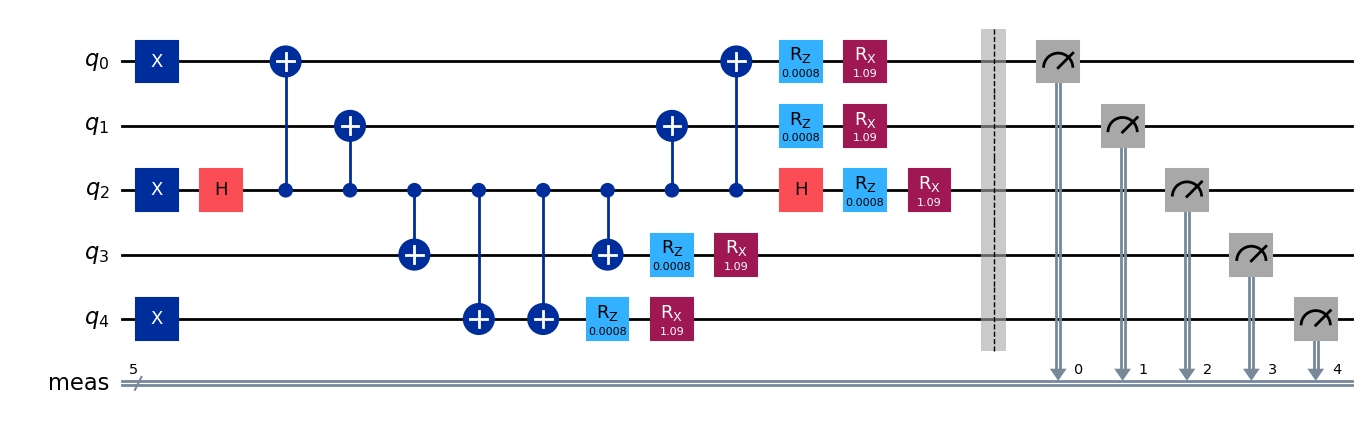

In [19]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params)
mcirc_post.draw('mpl')

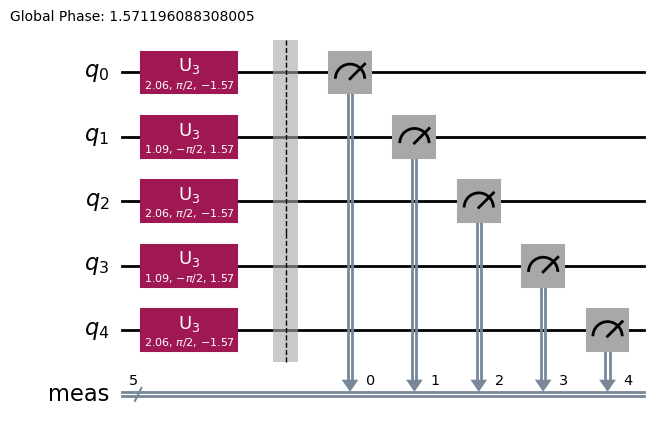

In [20]:
ideal_sim = AerSimulator()
transpiled_circ = transpile(mcirc_post, ideal_sim)
transpiled_circ.draw('mpl')

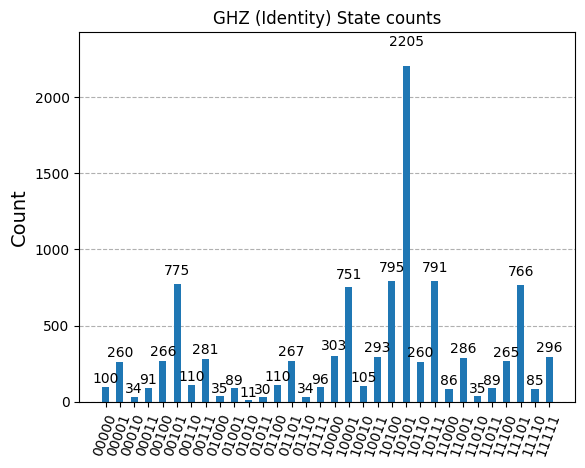

In [21]:
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')

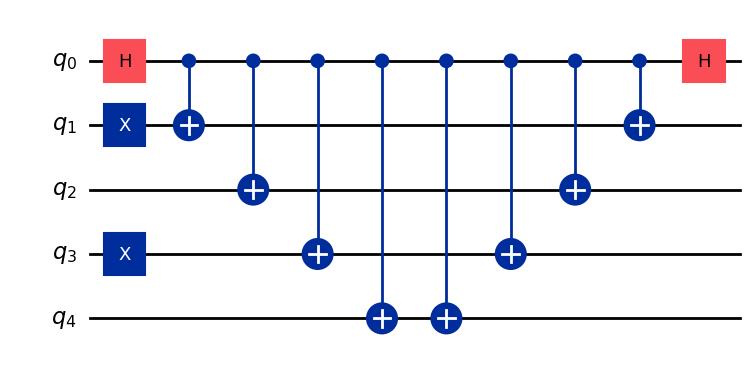

In [22]:
mcirc = get_circuit_for_model('01010', custom_ghz(5,0))
mcirc.draw('mpl')

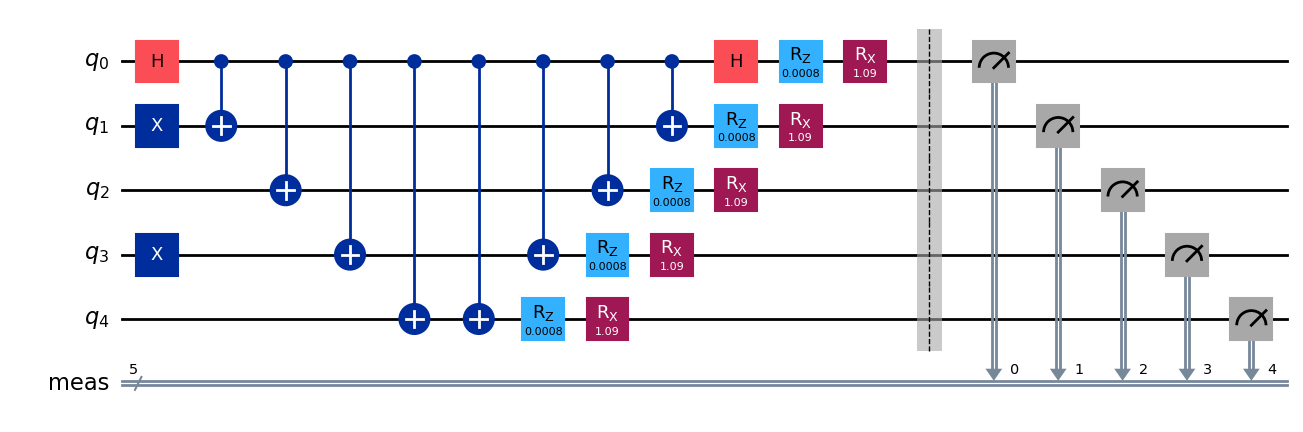

In [23]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params)
mcirc_post.draw('mpl')

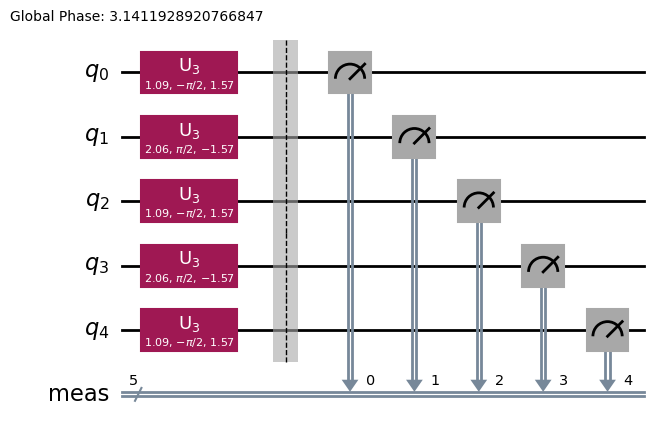

In [24]:
transpiled_circ = transpile(mcirc_post, ideal_sim)
transpiled_circ.draw('mpl')

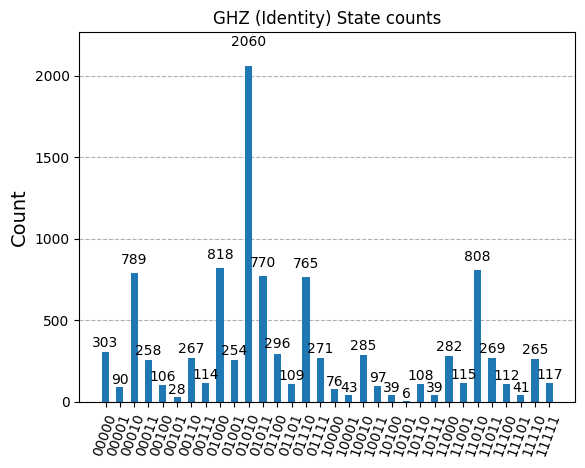

In [25]:
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')